In [1]:
import itertools

from matplotlib import pyplot as plt


# general utils
def display_table_with_colours(table):
    plt.imshow(table, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.show()

In [27]:
from typing import Optional

import numpy as np

from Core.EvaluatedFS import EvaluatedFS
from Core.FullSolution import FullSolution
from Core.PRef import PRef
from Core.PS import PS
from Core.PSMetric.Metric import Metric
from Core.SearchSpace import SearchSpace
import itertools
from sklearn.linear_model import LinearRegression



# first we make some classes, and gradually complete them


class LocalBivariateLinkageMetric(Metric):
    linkage_table: Optional[np.ndarray]
    original_pRef: Optional[PRef]
    local_pRef: Optional[PRef]
    solution: Optional[EvaluatedFS]

    def __init__(self):
        super().__init__()
        self.linkage_table = None
        self.original_pRef = None
        self.local_pRef = None

    def get_atomicity(self, ps: PS) -> float:
        fixed_vars = ps.get_fixed_variable_positions()
        if len(fixed_vars) >= 1:
            return self.linkage_table[fixed_vars][fixed_vars]
        else:
            return 0

    def get_single_score(self, ps: PS) -> float:
        return self.get_atomicity(ps)

    def set_pRef(self, pRef: PRef):
        self.original_pRef = pRef

    def set_solution(self, solution: EvaluatedFS):
        # this is where the heavy calculation goes
        self.solution = solution
        self.local_pRef = LocalBivariateLinkageMetric.get_local_pRef(self.original_pRef, self.solution)
        self.linkage_table = self.calculate_linkage_table()

    @classmethod
    def get_local_pRef(cls, original_pRef: PRef, solution: FullSolution):
        # all solutions are written in terms of [same var value as solution or not?]
        new_search_space = SearchSpace([2 for variable in original_pRef.search_space.cardinalities])
        full_solution_matrix = np.array(original_pRef.full_solution_matrix == solution.values, dtype=int)
        return PRef(fitness_array=original_pRef.fitness_array,
                    full_solution_matrix = full_solution_matrix,
                    search_space=new_search_space)#
    
    
    def display_linkage(self):
        display_table_with_colours(self.linkage_table)
        
        
    def make_input_table_with_interactions(self):
        transposed_fsm = self.local_pRef.full_solution_matrix.T
        original_columns = (column for column in transposed_fsm)
        paired_columns = (np.logical_and(col_a, col_b) for col_a, col_b in itertools.combinations(transposed_fsm, r=2))
        
        return np.array(list(itertools.chain(original_columns, paired_columns))).T
    
    
    def get_linear_model_with_interactions(self):
        vals_and_combinations = self.make_input_table_with_interactions()

        # Initialize and fit the linear model
        model = LinearRegression()  # i might change some settings here
        model.fit(vals_and_combinations, self.local_pRef.fitness_array)  
        
        return model
    
    def place_model_coefficients_in_table(self, model: LinearRegression):
        n:int = self.local_pRef.search_space.amount_of_parameters
        coefficients = model.coef_
        result = np.zeros(shape=(n, n), dtype=float)
        
        # note that first we set the "off diagonal", mirror it, and then set the diagonal
        result[np.triu_indices(n, 1)] = coefficients[n:]  # this relies on the order of columns produced by make_input_table_with_interactions
        result += result.T
        np.fill_diagonal(result, coefficients[:n])
        
        return result

    def calculate_linkage_table(self):
        linear_model = self.get_linear_model_with_interactions()
        return self.place_model_coefficients_in_table(linear_model)
        
        
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


def display_np(array):
    print(f"The shape is {array.shape}")
    display(array[:10])
    

In [34]:
from BenchmarkProblems.Checkerboard import CheckerBoard

# testing block, preparation

from Core.get_pRef import get_pRef_from_metaheuristic
# Check that reference populations and metrics work as intended

from Core.FullSolution import FullSolution
from Core.PS import PS, contains, STAR
from BenchmarkProblems.RoyalRoad import RoyalRoad

# first, we make a benchmark problem
problem = CheckerBoard(columns=4, rows=4)


# then we make a pRef
pRef = get_pRef_from_metaheuristic(problem=problem,
                                 sample_size=10000,
                                 which_algorithm="GA",
                                   unique=True,
                                 verbose=True)

best_solution = pRef.get_best_solution()
print("the best solution is ")
print(problem.repr_fs(best_solution))

Running the algorithm to generate the PRef using GA......Finished (took 1.026324 seconds)
the best solution is 
[0 1 0 1]
[1 0 1 0]
[0 1 0 1]
[1 0 1 0]


The shape is (762, 16)


array([[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]])

The shape is (762, 16)


array([[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]])

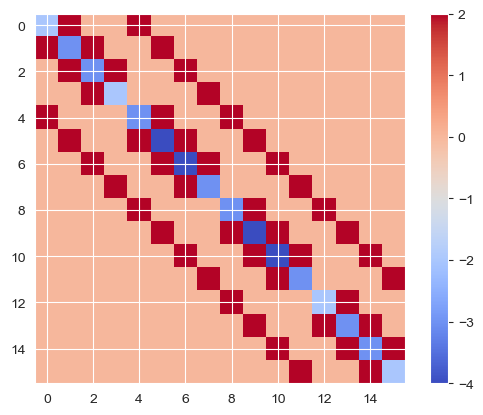

In [37]:
from Core.PSMetric.Linkage.DifferenceFromLinear import DifferenceFromLinear

general_model = DifferenceFromLinear()
general_model.set_pRef(pRef)
general_model.set_solution(best_solution)


display_np(general_model.original_pRef.full_solution_matrix)
display_np(general_model.local_pRef.full_solution_matrix)


display_table_with_colours(general_model.linkage_table)